In [28]:
# Import everything needed
from ReadFile import Read 
import numpy as np
import astropy.units as u
from CenterOfMass import CenterOfMass
from astropy.constants import G
import matplotlib.pyplot as plt
from astropy import constants as const

In [52]:
class MassProfile:
    # Used to determine the mass distribution of each galaxy at snap number 0
    # and use this to determine each galaxy’s rotation curve
    def __init__(self, galaxy, snap):
        ''' 
        Initialize the MassProfile with galaxy name and snapshot number
        
        Inputs:
        galaxy: Name of the galaxy (string)
        snap: Snapshot number used for filename generation (integer)
        
        Outputs:
        postions in units of kpc (float)
        mass of the galaxy (float)
        '''
        # Set the galaxy name as a global property
        self.gname = galaxy
        
        # Add a string of the filenumber to the value "000"
        ilbl = '000' + str(snap) 
        ilbl = ilbl[-3:]  
        self.filename = "%s_%s.txt" % (galaxy, ilbl)  # Format filename 
        
        # Read in data
        _, _, self.data = Read(self.filename)
        
        # Read in coords and mass data
        self.x = self.data["x"] * u.kpc  # x-coordinates in kpc
        self.y = self.data["y"] * u.kpc  # y-coordinates in kpc
        self.z = self.data["z"] * u.kpc  # z-coordinates in kpc
        self.m = self.data["m"]  # Mass
    
    def MassEnclosed(self,particle_type, radii_array):
        '''
        Computes the mass enclosed given the galaxy type and different radii
        
        Inputs: 
        particle_type: Used to calculate the positions of the particles (integer)
        radii_array: different radii we want to know what mass lies in (float)
        
        Outputs:
        mass_array: different masses enclosed for different radii in units of Msun (float)
        '''
        COM_object = CenterOfMass(self.filename,2) # Get the COM object
        COM_position = COM_object.COM_P(.1) # Gather the positions of the particles
        
        index = np.where(self.data['type'] == particle_type)
        xP = self.x - COM_position[0]
        yP = self.y - COM_position[1]
        zP = self.z - COM_position[2]
        
        xR = xP[index]
        yR = yP[index]
        zR = zP[index]
        mR = self.m[index]
        # Distance from COM in kpc
        distance = np.sqrt((xR)**2 + (yR)**2 + (zR)**2) 
        mass_enclosed = np.zeros(shape = len(radii_array)) # empty list for masses
        
        for radius in range(len(radii_array)):
            # This for loop goes through the radii array
            # and determines whether it is within the radius
            # and computes a sum for whatever particles are within
            # the given radii
            index_R = np.where(distance<radii_array[radius]* u.kpc)
            mass_tot = np.sum(mR[index_R])
            mass_enclosed[radius]= mass_tot
        mass_enclosed = mass_enclosed * 1e10    
        mass_enclosed = mass_enclosed # Convert units
        #into Msun units
        return mass_enclosed
    
    def MassEnclosedTotal(self,radii_array):
        '''
        Compute the total mass enclosed within specified radii for bulge, disk, and halo particles

        Inputs:
        radii_array: 1D array of radii at which to compute the enclosed mass (floats)

        Outputs:
        total_mass: 1D array of total enclosed mass (bulge + disk + halo) at each radius (float)
        '''
        # Initialize an array to store the mass
        total_mass = np.zeros(len(radii_array))

        # Compute the mass for disk particles
        disk_mass = self.MassEnclosed(2, radii_array) # Get disk mass for each radii
        total_mass += disk_mass  # Add disk mass to total

        # Compute the mass for halo particles
        halo_mass = self.MassEnclosed(1, radii_array)  # Get halo mass for each radii
        total_mass += halo_mass  # Add halo mass to total


        # Check if the galaxy has a bulge
        if self.gname != "M33":
            bulge_mass = self.MassEnclosed(3, radii_array)  # Get bulge mass for each radii
            total_mass += bulge_mass  # Add bulge mass to total


        total_mass = total_mass * u.Msun # Convert to solar masses
        return total_mass # return total mass

    def HernquistMass(self, radius, a, Mhalo):
        '''
        Compute the mass enclosed within a given radius using the Hernquist profile.

        Inputs:
        radius: The radius to compute the enclosed mass with units of kpc (float)
        a: The scale factor of the Hernquist profile in kpc (float)
        Mhalo: The total halo mass in units of Msun (float)

        Outputs:
        M_r: The enclosed mass at the given radius in Msun units (float)
        '''

        M_r = Mhalo * (radius**2) / ((radius + a)**2) # Apply the formula

        return M_r # returns the HernquistMass

    def CircularVelocity(self, particle_type, radii_array):
        '''
        Compute the circular velocity for a given particle type at each radius.

        Inputs:
        particle_type: The type of particles to compute each mass for (integer)
        radii_array: The radius array used to compute the circular velocity in units of kpc (float)

        Outputs:
        v_circ: array of circular velocities in units of km/s (float)
        '''
        # Change units of G to what we want
        G_value = const.G.to(u.kpc * u.km**(2) / u.s**(2) / u.M_sun)

        # Initialize array with desired units
        v_circ = np.zeros(len(radii_array))

        # Calculate the enclosed mass using massenclosed function in Msun units
        enclosed_mass = self.MassEnclosed(particle_type, radii_array)

        # Calculate the circular velocity
        v_circ = np.sqrt(G_value * enclosed_mass / radii_array) # Use formula

        # Return the circular velocities 
        circ_vel = np.round(v_circ, 2) # round to 2 decimal places and convert
        
        return circ_vel # returns given circular velocity

    def CircularVelocityTotal(self, radii_array):
        '''
        Compute the total circular velocity for every component

        Inputs:
        radii_array: array of radii in kpc used to calculate circular velocites(float)

        Outputs:
        v_circ_total: array of circular velocties in units of km/s (float)
        '''

        # Initialize the total mass array
        total_mass = np.zeros(len(radii_array)) * u.M_sun

        # Calculate the total enclosed mass
        total_mass = self.MassEnclosedTotal(radii_array)

        # Initialize circular velocity array 
        v_circ_total = np.zeros(len(radii_array))
        
        # Change units of G to what we want
        G_value = const.G.to(u.kpc * u.km**(2) / u.s**(2) / u.M_sun)
        
        # Calculate the circular velocity for a given array
        v_circ_total = np.sqrt(G_value * total_mass / radii_array) # Apply formula
        # Return the total circular velocity at every radii rounded and having desired units
        v_circ_total = np.round(v_circ_total, 2)
        
        return v_circ_total # returns total circular velocity
    def HernquistVCirc(self, radii_array, a, Mhalo):
        '''
        Compute the circular speed at a given radius using the Hernquist mass profile.

        Inputs:
        radius: The radius at which to compute the circular speed in kpc units (float)
        a: The scale factor of the Hernquist profile in kpc units (float)
        Mhalo: The total halo mass in Msun units (float)

        Outputs:
        v_circ: circular velocity from Hernquist Mass in km/s units (float)
        '''

        # Call the HernquistMass function to get enclosed mass
        M_r = self.HernquistMass(radii_array, a, Mhalo)

        # Change units of G to what we want
        G_value = const.G.to(u.kpc * u.km**(2) / u.s**(2) / u.M_sun)

        # Apply formula for circular velocity
        v_circ = np.sqrt(G_value * M_r / radii_array) #units of km/s
        
        # Get the circular velocity
        v_circ_Hernquist = np.round(v_circ,2)  # Convert to km/s and round

        return v_circ_Hernquist # return desired value

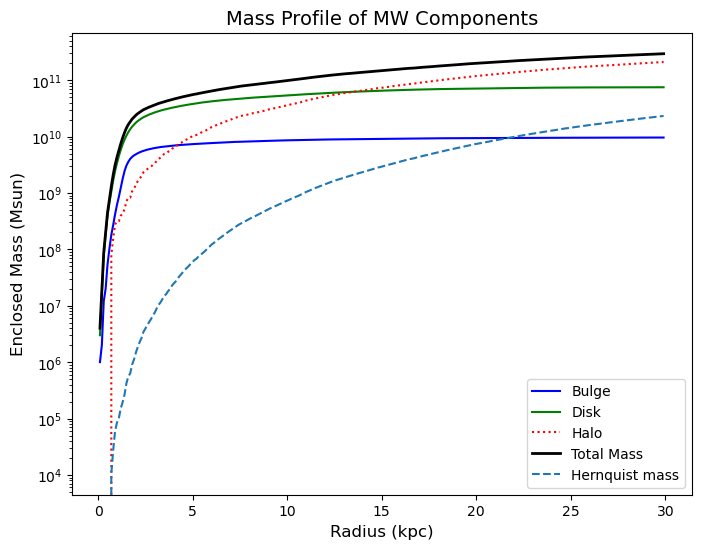

In [53]:
# Create an instance for Milky Way Mass Profile
mass_profile = MassProfile(galaxy="MW", snap=0) 

# Make radii array
radii = np.arange(0.1,30,.1) # Choose 100 radii

# Compute enclosed mass for bulge, disk, and halo
mass_bulge = mass_profile.MassEnclosed(3, radii)
mass_disk = mass_profile.MassEnclosed(2, radii)
mass_halo = mass_profile.MassEnclosed(1, radii)

a = 60 # We did this in class

mass_hernquist = mass_profile.HernquistMass(radii,a,mass_halo)
# Compute the total mass enclosed
mass_total = mass_profile.MassEnclosedTotal(radii)

# Plotting
plt.figure(figsize=(8, 6))

# Plot individual components
plt.semilogy(radii, mass_bulge, label='Bulge', linestyle='-', color='b')
plt.semilogy(radii, mass_disk, label='Disk', linestyle='solid', color='g')
plt.semilogy(radii, mass_halo, label='Halo', linestyle=':', color='r')

# Plot the total mass enclosed
plt.semilogy(radii, mass_total, label='Total Mass', linestyle='-', color='k', linewidth=2)
plt.semilogy(radii, mass_hernquist, label='Hernquist mass', linestyle='--')
# Adding labels and legend
plt.xlabel('Radius (kpc)', fontsize=12)
plt.ylabel('Enclosed Mass (Msun)', fontsize=12)
plt.title('Mass Profile of MW Components', fontsize=14)
plt.legend()

# Show the plot
plt.show()

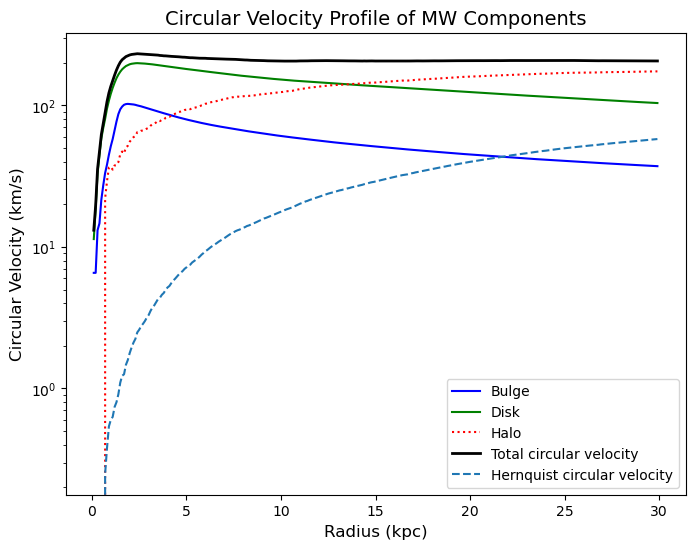

In [54]:
# Create an instance for Milky Way Circular Velocity Profile
mass_profile = MassProfile(galaxy="MW", snap=0) 

# Make radii array
radii = np.arange(0.1,30,.1) # Choose 100 radii

# Compute enclosed mass for bulge, disk, and halo
circ_vel_bulge = mass_profile.CircularVelocity(3, radii)
circ_vel_disk = mass_profile.CircularVelocity(2, radii)
circ_vel_halo = mass_profile.CircularVelocity(1, radii)

a = 60 # We did this in class

circ_vel_hernquist = mass_profile.HernquistVCirc(radii,a,mass_halo)
# Compute the total mass enclosed
circ_vel_total = mass_profile.CircularVelocityTotal(radii)

# Plotting
plt.figure(figsize=(8, 6))

# Plot individual components
plt.semilogy(radii, circ_vel_bulge, label='Bulge', linestyle='-', color='b')
plt.semilogy(radii, circ_vel_disk, label='Disk', linestyle='solid', color='g')
plt.semilogy(radii, circ_vel_halo, label='Halo', linestyle=':', color='r')

# Plot the total mass enclosed
plt.semilogy(radii, circ_vel_total, label='Total circular velocity', linestyle='-', color='k', linewidth=2)
plt.semilogy(radii, circ_vel_hernquist, label='Hernquist circular velocity', linestyle='--')
# Adding labels and legend
plt.xlabel('Radius (kpc)', fontsize=12)
plt.ylabel('Circular Velocity (km/s)', fontsize=12)
plt.title('Circular Velocity Profile of MW Components', fontsize=14)
plt.legend()

# Show the plot
plt.show()

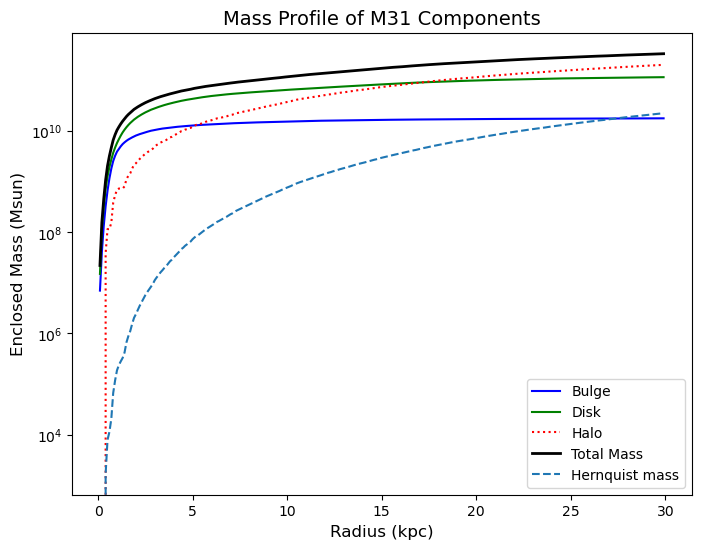

In [56]:
# Create an instance for M31
mass_profile = MassProfile(galaxy="M31", snap=0) 

# Make radii array
radii = np.arange(0.1,30,.1) # Choose 100 radii

# Compute enclosed mass for bulge, disk, and halo
mass_bulge = mass_profile.MassEnclosed(3, radii)
mass_disk = mass_profile.MassEnclosed(2, radii)
mass_halo = mass_profile.MassEnclosed(1, radii)

a = 60 # We did this in class

mass_hernquist = mass_profile.HernquistMass(radii,a,mass_halo)
# Compute the total mass enclosed
mass_total = mass_profile.MassEnclosedTotal(radii)

# Plotting
plt.figure(figsize=(8, 6))

# Plot individual components
plt.semilogy(radii, mass_bulge, label='Bulge', linestyle='-', color='b')
plt.semilogy(radii, mass_disk, label='Disk', linestyle='solid', color='g')
plt.semilogy(radii, mass_halo, label='Halo', linestyle=':', color='r')

# Plot the total mass enclosed
plt.semilogy(radii, mass_total, label='Total Mass', linestyle='-', color='k', linewidth=2)
plt.semilogy(radii, mass_hernquist, label='Hernquist mass', linestyle='--')
# Adding labels and legend
plt.xlabel('Radius (kpc)', fontsize=12)
plt.ylabel('Enclosed Mass (Msun)', fontsize=12)
plt.title('Mass Profile of M31 Components', fontsize=14)
plt.legend()

# Show the plot
plt.show()

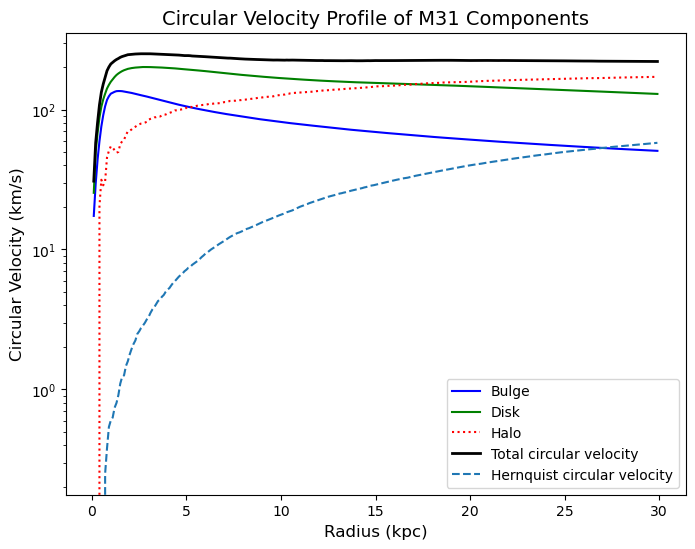

In [55]:
# Create an instance for M31 Circular Velocity Profile
mass_profile = MassProfile(galaxy="M31", snap=0) 

# Make radii array
radii = np.arange(0.1,30,.1) # Choose 100 radii

# Compute enclosed mass for bulge, disk, and halo
circ_vel_bulge = mass_profile.CircularVelocity(3, radii)
circ_vel_disk = mass_profile.CircularVelocity(2, radii)
circ_vel_halo = mass_profile.CircularVelocity(1, radii)

a = 60 # We did this in class

circ_vel_hernquist = mass_profile.HernquistVCirc(radii,a,mass_halo)
# Compute the total mass enclosed
circ_vel_total = mass_profile.CircularVelocityTotal(radii)

# Plotting
plt.figure(figsize=(8, 6))

# Plot individual components
plt.semilogy(radii, circ_vel_bulge, label='Bulge', linestyle='-', color='b')
plt.semilogy(radii, circ_vel_disk, label='Disk', linestyle='solid', color='g')
plt.semilogy(radii, circ_vel_halo, label='Halo', linestyle=':', color='r')

# Plot the total mass enclosed
plt.semilogy(radii, circ_vel_total, label='Total circular velocity', linestyle='-', color='k', linewidth=2)
plt.semilogy(radii, circ_vel_hernquist, label='Hernquist circular velocity', linestyle='--')
# Adding labels and legend
plt.xlabel('Radius (kpc)', fontsize=12)
plt.ylabel('Circular Velocity (km/s)', fontsize=12)
plt.title('Circular Velocity Profile of M31 Components', fontsize=14)
plt.legend()

# Show the plot
plt.show()

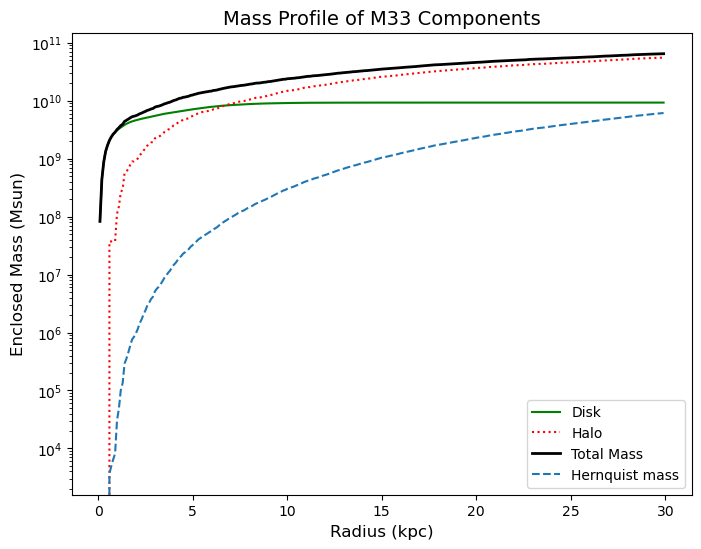

In [57]:
# Create an instance for M33
mass_profile = MassProfile(galaxy="M33", snap=0) 

# Make radii array
radii = np.arange(0.1,30,.1) # Choose 100 radii

# Compute enclosed mass for bulge, disk, and halo
mass_disk = mass_profile.MassEnclosed(2, radii)
mass_halo = mass_profile.MassEnclosed(1, radii)

a = 60 # We did this in class

mass_hernquist = mass_profile.HernquistMass(radii,a,mass_halo)
# Compute the total mass enclosed
mass_total = mass_profile.MassEnclosedTotal(radii)

# Plotting
plt.figure(figsize=(8, 6))

# Plot individual components
plt.semilogy(radii, mass_disk, label='Disk', linestyle='solid', color='g')
plt.semilogy(radii, mass_halo, label='Halo', linestyle=':', color='r')

# Plot the total mass enclosed
plt.semilogy(radii, mass_total, label='Total Mass', linestyle='-', color='k', linewidth=2)
plt.semilogy(radii, mass_hernquist, label='Hernquist mass', linestyle='--')
# Adding labels and legend
plt.xlabel('Radius (kpc)', fontsize=12)
plt.ylabel('Enclosed Mass (Msun)', fontsize=12)
plt.title('Mass Profile of M33 Components', fontsize=14)
plt.legend()

# Show the plot
plt.show()

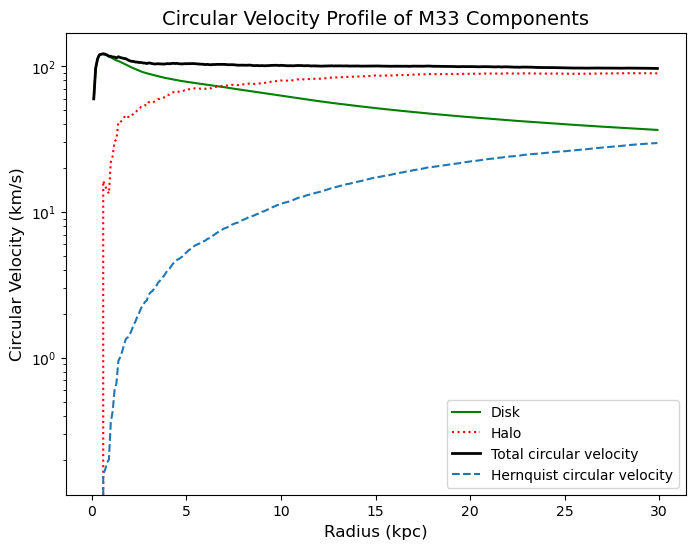

In [59]:
# Create an instance for Milky Way Circular Velocity Profile
mass_profile = MassProfile(galaxy="M33", snap=0) 

# Make radii array
radii = np.arange(0.1,30,.1) # Choose 100 radii

# Compute enclosed mass for bulge, disk, and halo
circ_vel_disk = mass_profile.CircularVelocity(2, radii)
circ_vel_halo = mass_profile.CircularVelocity(1, radii)

a = 60 # We did this in class

circ_vel_hernquist = mass_profile.HernquistVCirc(radii,a,mass_halo)
# Compute the total mass enclosed
circ_vel_total = mass_profile.CircularVelocityTotal(radii)

# Plotting
plt.figure(figsize=(8, 6))

# Plot individual components
plt.semilogy(radii, circ_vel_disk, label='Disk', linestyle='solid', color='g')
plt.semilogy(radii, circ_vel_halo, label='Halo', linestyle=':', color='r')

# Plot the total mass enclosed
plt.semilogy(radii, circ_vel_total, label='Total circular velocity', linestyle='-', color='k', linewidth=2)
plt.semilogy(radii, circ_vel_hernquist, label='Hernquist circular velocity', linestyle='--')
# Adding labels and legend
plt.xlabel('Radius (kpc)', fontsize=12)
plt.ylabel('Circular Velocity (km/s)', fontsize=12)
plt.title('Circular Velocity Profile of M33 Components', fontsize=14)
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Changing the a values did nothing when I tried...